In [1]:
import os

os.chdir('..')

In [2]:
import time
import logging

# External packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# Local modules
from src.nids.kitnet import KitNET

In [3]:
# Hyperparameters
max_autoencoder_size = 10

In [4]:
data_filename = "data/mirai/mirai3.csv"
timestamp_filename = "data/mirai/mirai3_ts.csv"

X = pd.read_csv(data_filename, header=None).values
timestamps = pd.read_csv(timestamp_filename,header=None).values
print(X[:2])

[[ 1.89742e+00  6.81526e+01  4.69271e+01  2.30082e+00  6.86038e+01
   4.61262e+01  4.74452e+00  7.11236e+01  3.84705e+01  3.60737e+01
   7.37076e+01  2.05623e+01  3.00568e+02  7.41529e+01  2.21900e+01
   1.89742e+00  6.81526e+01  4.69271e+01  2.30082e+00  6.86038e+01
   4.61262e+01  4.74452e+00  7.11236e+01  3.84705e+01  3.60737e+01
   7.37076e+01  2.05623e+01  3.00568e+02  7.41529e+01  2.21900e+01
   1.81304e+00  6.79605e+01  6.93379e+00  9.60435e+01  6.81146e+01
   1.87874e+01  3.90070e-01  2.00156e+00  6.79643e+01  6.93326e+00
   9.60782e+01  6.80525e+01  1.47101e+01  3.05694e-01  2.93222e+00
   6.94536e+01  6.55592e+00  9.82134e+01  6.08259e+01  1.28515e+01
   2.98799e-01  1.62590e+01  7.26847e+01  4.08470e+00  1.02791e+02
   2.35975e+01  1.38934e+01  8.32637e-01  1.50608e+02  7.33069e+01
   3.03690e+00  1.03672e+02  1.30428e+01  8.57403e+00  9.29670e-01
   1.81304e+00  4.62345e-01  1.88561e-01  2.00156e+00  5.11620e-01
   1.94293e-01  2.93222e+00  6.69755e-01  1.86623e-01  1.62590

In [5]:
X_fm = X[:5000]
X_train = X[5000:55000]
X_test = X[55000:]

In [6]:
model = KitNET(X_fm.shape[1], max_autoencoder_size, random_state=1234)

In [7]:
tic = time.perf_counter()
model.fit(X_fm, X_train)

toc = time.perf_counter()
print(f"Fitting complete. Time elapsed: {toc - tic:.4f}")

Fitting complete. Time elapsed: 24.3908


In [8]:
tic = time.perf_counter()
errors = model.evaluate_errors(X_test)
toc = time.perf_counter()
print(f"Error evaluation complete. Time elapsed: {toc - tic:.4f}")

Error evaluation complete. Time elapsed: 12.3082


In [9]:
# Calibrate log-distribution

benign_examples = np.log(errors[:71000-55000])
log_probs = norm.logsf(np.log(errors), np.mean(benign_examples), np.std(benign_examples))

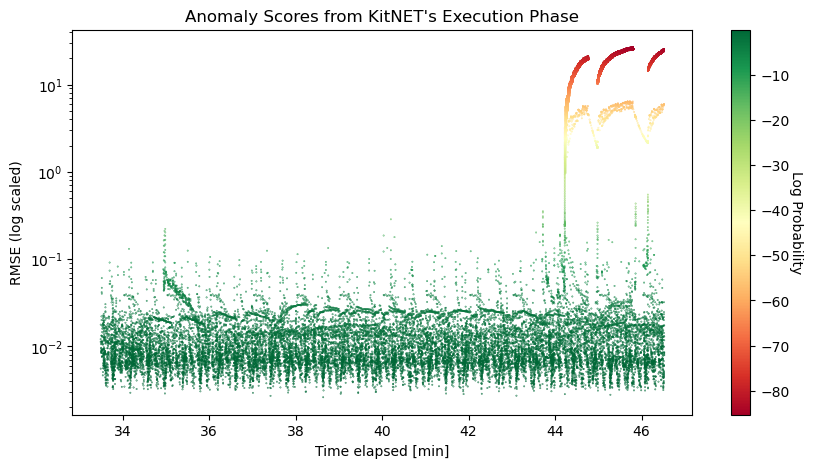

In [10]:
plt.figure(figsize=(10,5))
fig = plt.scatter(
    timestamps[55000:],
    errors,
    s=0.1,
    c=log_probs,
    cmap='RdYlGn'
)
plt.yscale("log")
plt.title("Anomaly Scores from KitNET's Execution Phase")
plt.ylabel("RMSE (log scaled)")
plt.xlabel("Time elapsed [min]")
figbar = plt.colorbar()
figbar.ax.set_ylabel('Log Probability\n ', rotation=270, labelpad=10)
plt.show()

In [11]:
filename = "data/cicids2017/cicids2017_random10.csv"

df = pd.read_csv(filename)
print(df.head())

       id                                 Flow ID        Src IP  Src Port  \
0  361687  192.168.10.3-224.0.0.252-50146-5355-17  192.168.10.3     50146   
1  150029         192.168.10.1-192.168.10.3-0-0-1  192.168.10.1         0   
2  366866   192.168.10.9-192.168.10.3-49474-53-17  192.168.10.9     49474   
3  308688  192.168.10.9-208.185.118.105-1048-80-6  192.168.10.9      1048   
4  370916     192.168.10.9-192.168.10.3-1052-88-6  192.168.10.9      1052   

            Dst IP  Dst Port  Protocol                   Timestamp  \
0      224.0.0.252      5355        17  2017-07-03 11:56:41.708405   
1     192.168.10.3         0         1  2017-07-03 11:56:41.708710   
2     192.168.10.3        53        17  2017-07-03 11:56:45.578172   
3  208.185.118.105        80         6  2017-07-03 11:56:58.508783   
4     192.168.10.3        88         6  2017-07-03 11:56:58.852248   

   Flow Duration  Total Fwd Packet  ...  Active Min   Idle Mean  Idle Std  \
0         420566                18  ...

In [12]:
non_feature_columns = ['id', 'Flow ID', 'Timestamp', 'Src IP', 'Dst IP', 'Label', 'Attempted Category']

X = df.drop(columns=non_feature_columns).values
timestamps = pd.to_datetime(df['Timestamp']).astype(int) / 10**9
labels = df['Label']

In [13]:
X.dtype  # verify that all features are floats

dtype('float64')

In [14]:
X_benign = X[labels == 'BENIGN']
ts_benign = timestamps[labels == 'BENIGN']

X_anomaly = X[labels != 'BENIGN']
ts_anomaly = timestamps[labels != 'BENIGN']
labels = labels[labels != 'BENIGN']

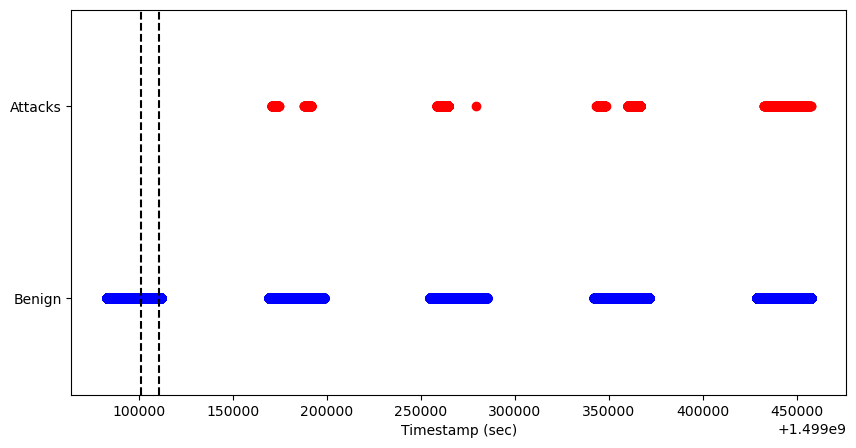

In [15]:
plt.figure(figsize=(10,5))
plt.scatter(ts_benign, np.zeros(ts_benign.shape[0]), c='blue', label='Benign')
plt.scatter(ts_anomaly, np.ones(ts_anomaly.shape[0]), c='red', label='Attacks')
plt.vlines(x=[ts_benign[25_000], ts_benign[35_000]], ymin=[-0.5], ymax=[1.5], colors=['k'], linestyles=['--'])
plt.yticks([0, 1], ['Benign', 'Attacks'])
plt.ylim([-0.5, 1.5])
plt.xlabel('Timestamp (sec)')
plt.show()

In [16]:
X_fm = X_benign[:5000]
X_train = X_benign[5000:25000]

# calibrate on 25000:35000
X_benign_test = X_benign[25000:]

In [17]:
model = KitNET(X_fm.shape[1], max_autoencoder_size, random_state=42)

In [18]:
tic = time.perf_counter()
model.fit(X_fm, X_train)

toc = time.perf_counter()
print(f"Fitting complete. Time elapsed: {toc - tic:.4f}")

Fitting complete. Time elapsed: 16.0661


In [19]:
tic = time.perf_counter()
errors_benign = model.evaluate_errors(X_benign_test)
errors_anomaly = model.evaluate_errors(X_anomaly)
toc = time.perf_counter()
print(f"Error evaluation complete. Time elapsed: {toc - tic:.4f}")

Error evaluation complete. Time elapsed: 82.4718


In [20]:
# Calibrate log-distribution

benign_examples = np.log(errors_benign[:10_000])

mu = np.mean(benign_examples)
sigma = np.std(benign_examples)
log_probs_benign = norm.logsf(np.log(errors_benign), mu, sigma)
log_probs_anomaly = norm.logsf(np.log(errors_anomaly), mu, sigma)

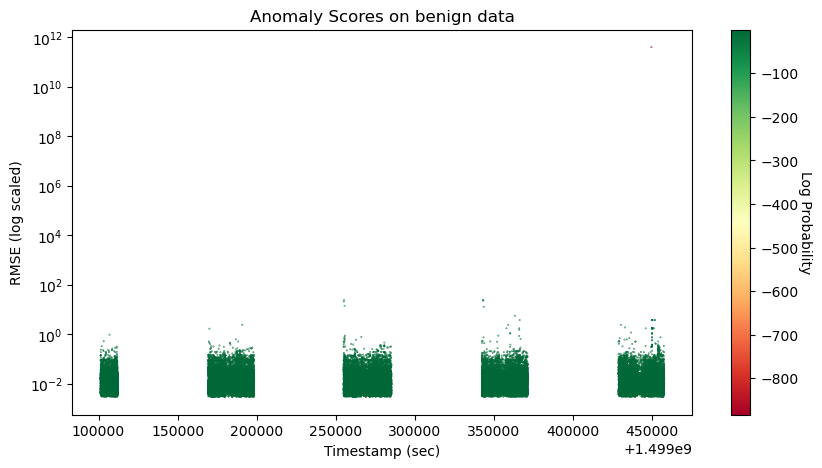

In [21]:
plt.figure(figsize=(10,5))
fig = plt.scatter(
    ts_benign[25000:],
    errors_benign,
    s=0.1,
    c=log_probs_benign,
    cmap='RdYlGn'
)
plt.yscale("log")
plt.title("Anomaly Scores on benign data")
plt.ylabel("RMSE (log scaled)")
plt.xlabel('Timestamp (sec)')
figbar = plt.colorbar()
figbar.ax.set_ylabel('Log Probability\n ', rotation=270, labelpad=10)
plt.show()

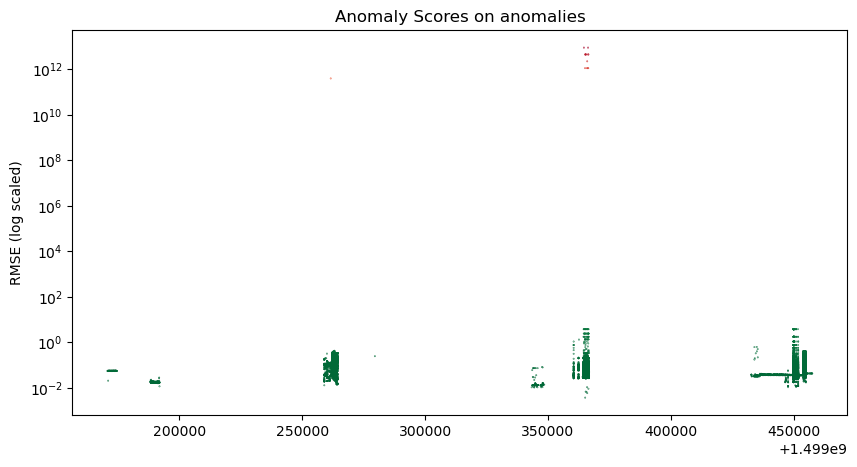

In [22]:
plt.figure(figsize=(10,5))
fig = plt.scatter(
    ts_anomaly,
    errors_anomaly,
    s=0.1,
    c=log_probs_anomaly,
    cmap='RdYlGn'
)
plt.yscale("log")
plt.title("Anomaly Scores on anomalies")
plt.ylabel("RMSE (log scaled)")
plt.show()